<center>
    <h1>ENSO Demo</h1>
    <h3>Principal component analysis, spectral analysis, and other fun stuff</h3>
</center>

In [91]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

%matplotlib inline

## Background

[El Ni&ntilde;o-Southern Oscillation (ENSO)](https://www.ncdc.noaa.gov/teleconnections/enso/) is a quasiperiodic fluctuation in sea surface temperatures (SSTs) and atmospheric pressure over the equatorial Pacific Ocean. It is characterized primarily by anomalously warm (El Ni&ntilde;o) or cool (La Ni&ntilde;a) SSTs in the central/Eastern equatorial Pacific, accompanied by bimodal variations in sea level pressure (Southern Oscillation) and many other changes in the coupled atmosphere-ocean system. These oscillations typically occur with a periodicity of about 2-7 years.

In this Jupyter notebook, I will show how principal component analysis and spectral analysis can provide insights into the ENSO phenomenon.

## Sea surface temperature data

For SSTs, I'm using [ERSST v.5](https://www.ncdc.noaa.gov/data-access/marineocean-data/extended-reconstructed-sea-surface-temperature-ersst-v5) from NOAA, a dataset of SSTs reconstructed from historical measurements aboard ships (1880-1970s), and from marine and satellite measurements in the modern satellite era (1979-present). This is a gridded global dataset, with a resolution of 2$^{\circ}$ latitude $\times$ 2$^{\circ}$ longitude.

First, use the [xarray](https://xarray.pydata.org/en/stable/) package to load the data from a `netcdf` file into an `xarray.Dataset` variable:

In [22]:
datafile = 'data/ERSST_v5_1880-2016.nc'
with xr.open_dataset(datafile) as ds:
    ds.load()
ds.coords['month'] = ds['time'].dt.month
ds.coords['year'] = ds['time'].dt.year
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lev: 1, lon: 180, time: 1644)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lev      (lev) float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 1880-03-01 ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
    year     (time) int64 1880 1880 1880 1880 1880 1880 1880 1880 1880 1880 ...
Data variables:
    sst      (time, lev, lat, lon) float32 nan nan nan nan nan nan nan nan ...
    ssta     (time, lev, lat, lon) float32 nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.188001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v

Our variable of interest is the `'sst'` variable:

In [23]:
sst = ds['sst'].squeeze('lev')
sst

<xarray.DataArray 'sst' (time: 1644, lat: 89, lon: 180)>
array([[[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ],
        [-1.8     , -1.8     , ..., -1.8     , -1.8     ]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.501715, -1.445426, ..., -1.601185, -1.551831],
        [-1.484895, -1.482075, ..., -1.525675, -1.494519]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [-1.778139, -1.787428, ..., -1.790978,

Define the latitude and longitude extents for our equatorial Pacific domain:

In [29]:
lon1, lon2 = 160, 260
lat1, lat2 = -10, 10

Map of climatological mean SSTs, showing boundaries of our equatorial Pacific domain:

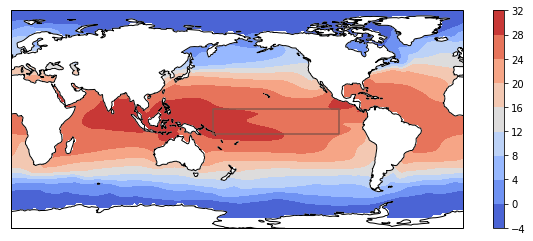

In [130]:
plt.figure(figsize=(11, 4))
proj = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=proj)
plt.contourf(sst['lon'], sst['lat'], sst.mean(dim='time'), cmap='coolwarm', transform=ccrs.PlateCarree())
plt.colorbar()
cf = cfeature.NaturalEarthFeature('physical', 'land', '110m')
ax.add_feature(cf, color='w')
ax.coastlines()
plt.plot([lon1, lon1, lon2, lon2, lon1], [lat1, lat2, lat2, lat1, lat1], 
         color='C5', transform=ccrs.PlateCarree())

Extract SST data for the equatorial Pacific domain and plot the climatological mean for this domain:

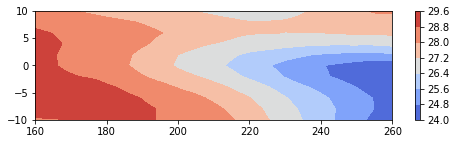

In [131]:
var = sst.sel(lon=slice(lon1, lon2), lat=slice(lat1, lat2))
plt.figure(figsize=(8, 2))
plt.contourf(var['lon'], var['lat'], var.mean(dim='time'), cmap='coolwarm')
plt.colorbar();

In [71]:
((var['year'] == year) & (var['month'] == month))

<xarray.DataArray (time: 1644)>
array([False, False, False, ..., False, False, False])
Coordinates:
    lev      float64 0.0
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 1880-03-01 ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
    year     (time) int64 1880 1880 1880 1880 1880 1880 1880 1880 1880 1880 ...

In [75]:
var_yr.where(var['month'] == 1, drop=True).squeeze()

<xarray.DataArray (lat: 11, lon: 51)>
array([[29.6187  , 29.61694 , 29.597164, ..., 25.130383, 24.939352, 24.780725],
       [29.736923, 29.753788, 29.722105, ..., 25.490244, 25.371624, 25.283918],
       [29.752546, 29.774015, 29.747566, ..., 25.62676 , 25.575779, 25.53392 ],
       ...,
       [28.97626 , 28.960487, 28.921976, ..., 27.582376, 27.57312 , 27.556314],
       [28.48196 , 28.494707, 28.438385, ..., 27.893478, 27.850496, 27.794338],
       [27.96416 , 27.922434, 27.891972, ..., 28.222612, 28.195091, 28.097124]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 1988-01-01
  * lat      (lat) float64 -10.0 -8.0 -6.0 -4.0 -2.0 0.0 2.0 4.0 6.0 8.0 10.0
    lev      float64 0.0
  * lon      (lon) float64 160.0 162.0 164.0 166.0 168.0 170.0 172.0 174.0 ...
    month    int64 1
    year     int64 1988
Attributes:
    long_name:      Extended reconstructed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          degree_C
    valid_min:   

In [77]:
axes.ravel()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002BC1437F550>,
      dtype=object)

In [79]:
var_plot

<xarray.DataArray (lat: 11, lon: 51)>
array([[29.6187  , 29.61694 , 29.597164, ..., 25.130383, 24.939352, 24.780725],
       [29.736923, 29.753788, 29.722105, ..., 25.490244, 25.371624, 25.283918],
       [29.752546, 29.774015, 29.747566, ..., 25.62676 , 25.575779, 25.53392 ],
       ...,
       [28.97626 , 28.960487, 28.921976, ..., 27.582376, 27.57312 , 27.556314],
       [28.48196 , 28.494707, 28.438385, ..., 27.893478, 27.850496, 27.794338],
       [27.96416 , 27.922434, 27.891972, ..., 28.222612, 28.195091, 28.097124]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 1988-01-01
  * lat      (lat) float64 -10.0 -8.0 -6.0 -4.0 -2.0 0.0 2.0 4.0 6.0 8.0 10.0
    lev      float64 0.0
  * lon      (lon) float64 160.0 162.0 164.0 166.0 168.0 170.0 172.0 174.0 ...
    month    int64 1
    year     int64 1988
Attributes:
    long_name:      Extended reconstructed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          degree_C
    valid_min:   

In [86]:
def colorbar_multiplot(**kwargs):
    """Create a single colorbar for all subplots in a figure."""
    cb = plt.colorbar(ax=plt.gcf().get_axes(), **kwargs)
    return cb

In [ ]:
plt.colorbar()

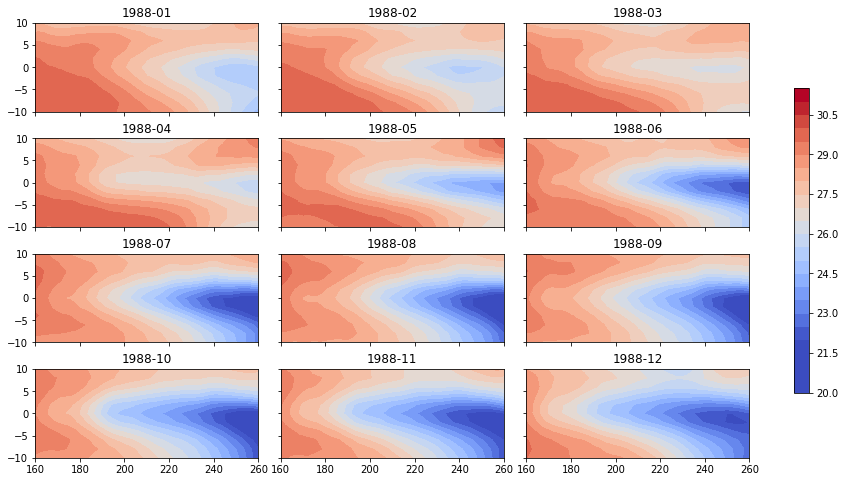

In [123]:
year = 1988
months = range(1, 13)
clevels = np.arange(20, 32, 0.5)
cticks = np.arange(22, 32, 1)
climits = 22, 31

fig, axes = plt.subplots(4, 3, figsize=(16, 8), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.1)
for month, ax in zip(months, axes.ravel()):
    plt.sca(ax)
    var_plot = var.where((var['year'] == year) & (var['month'] == month), drop=True).squeeze()
    plt.contourf(var_plot['lon'], var_plot['lat'], var_plot, clevels, cmap='coolwarm')
    plt.clim(climits)
    plt.title(f'{year}-{month:02d}')
cb = colorbar_multiplot(orientation='vertical', shrink=0.7,  boundaries=np.arange(22, 31.1, 0.5))

In [117]:
cb.boundaries

array([20. , 20.5, 21. , 21.5, 22. , 22.5, 23. , 23.5, 24. , 24.5, 25. ,
       25.5, 26. , 26.5, 27. , 27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5,
       31. , 31.5])

In [24]:
with xr.open_dataset('data/SST_ERAInterim_monthly_Jan1979_Jun2017_Tropical_Pacific.nc') as ds2:
    ds2.load()
ds2

<xarray.Dataset>
Dimensions:    (latitude: 29, longitude: 135, time: 462)
Coordinates:
  * longitude  (longitude) float32 159.75 160.5 161.25 162.0 162.75 163.5 ...
  * latitude   (latitude) float32 10.5 9.75 9.0 8.25 7.5 6.75 6.0 5.25 4.5 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    sst        (time, latitude, longitude) float32 300.94366 300.9118 ...
Attributes:
    Conventions:  CF-1.6
    history:      2017-09-25 20:57:48 GMT by grib_to_netcdf-2.4.0: grib_to_ne...

In [27]:
ds2['longitude'].to_series().describe()

count    135.000000
mean     210.000000
std       29.336411
min      159.750000
25%      184.875000
50%      210.000000
75%      235.125000
max      260.250000
Name: longitude, dtype: float64

In [28]:
ds2['latitude'].to_series().describe()

count    29.00000
mean      0.00000
std       6.38602
min     -10.50000
25%      -5.25000
50%       0.00000
75%       5.25000
max      10.50000
Name: latitude, dtype: float64

In [24]:
time = data['time']
time.dt.month

<xarray.DataArray 'month' (time: 1644)>
array([ 1,  2,  3, ..., 10, 11, 12], dtype=int64)
Coordinates:
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 1880-03-01 ...

In [32]:
data.coords['month'] = data['time'].dt.month
data

<xarray.Dataset>
Dimensions:  (lat: 89, lev: 1, lon: 180, time: 1644)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lev      (lev) float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 1880-03-01 ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
Data variables:
    sst      (time, lev, lat, lon) float32 nan nan nan nan nan nan nan nan ...
    ssta     (time, lev, lat, lon) float32 nan nan nan nan nan nan nan nan ...
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.188001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    institution:                NOAA/N

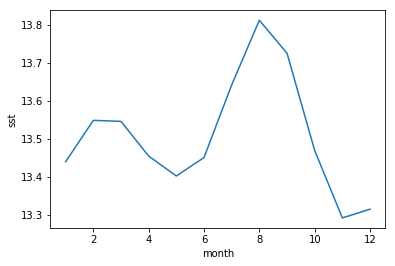

In [38]:
data['sst'].groupby('month').mean().plot()

In [37]:
data['sst']

<xarray.DataArray 'sst' (time: 1644, lev: 1, lat: 89, lon: 180)>
array([[[[      nan, ...,       nan],
         ...,
         [-1.8     , ..., -1.8     ]]],


       ...,


       [[[      nan, ...,       nan],
         ...,
         [-1.772647, ..., -1.772422]]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 -74.0 ...
  * lev      (lev) float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 10.0 12.0 14.0 16.0 18.0 20.0 ...
  * time     (time) datetime64[ns] 1880-01-01 1880-02-01 1880-03-01 ...
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 12 1 2 3 4 5 6 7 8 9 10 11 ...
Attributes:
    long_name:      Extended reconstructed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          degree_C
    valid_min:      -3.0
    valid_max:      45.0